In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from matplotlib.patches import Patch
import mygene
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text
import dask.dataframe as dd

In the first step, the expected counts from each of the individual RSEM output files are combined together to create the combined count matrix for the whole dataset

In [2]:

def create_combined_count_matrix(folder_path):
    """
    Create a combined count matrix from all the individual RSEM files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the RSEM files.

    Returns:
        pandas DataFrame: The combined count matrix for the dataset
    """
    # empty list to store the individual count dataframes
    count_dfs = []

    # Iterate over all RSEM output files in the folder
    for file_name in os.listdir(folder_path):
       
        # Generate the full path to access file
        file_path = os.path.join(folder_path, file_name)
        # Read the file into a Dask DataFrame, extract the gene_id and expected_count columns
        count_df = dd.read_csv(file_path, sep='\t', usecols=['gene_id', 'expected_count'])
            
        # Assign the sample name (derived from file name)
        sample_name = file_name.split(".")[0]
        count_df = count_df.rename(columns={'expected_count': sample_name})
            
        # change the index to gene_id column
        count_df = count_df.set_index('gene_id')
            
        # Add the count data frame to the count_dfs list
        count_dfs.append(count_df)

    # Merge all individual count data frames based on same index (gene_id)
    count_matrix = dd.concat(count_dfs, axis=1)
    # Fill NaN values with 0 (in case of missing values)
    count_matrix = count_matrix.fillna(0)
    # Convert the expected counts to integer values which is necessary for DESeq2
    count_matrix = count_matrix.round().astype(int)
    # Compute the final DataFrame
    count_matrix = count_matrix.compute()
    #return the count matrix
    return count_matrix

# The folder path contating the RSEM files
folder_path = '../GSE205099_RAW'
# Generate the combined count matrix
counts_df = create_combined_count_matrix(folder_path)
# Save the count matrix
counts_df.to_csv(f'{folder_path}_count_matrix.tsv', sep='\t')
print("Count matrix created successfully!")


Count matrix created successfully!


We convert the Ensembl ids to corresponding gene symbol. In case of multiple Ensembl IDs pointing to the same genesymbol, we added their counts together for the respective replicates

In [3]:

def process_counts_df(counts_df):
    """
    To Process the counts dataframe by mapping the Ensembl IDs to Corresponding Gene Symbols and Perform additional transformations.

    Args:
        counts_df (pandas DataFrame): The counts matrix dataframe containing Ensembl IDs as index and gene counts as columns.

    Returns:
        counts_df: The processed counts matrix dataframe.
    """
    # Initialize the mygene object
    my_gene_object = mygene.MyGeneInfo()

    # Extract the Ensembl IDs without version numbers 
    ensembl_ids = counts_df.index.str.split('.').str[0].unique()

    # Query the IDs to fetch the corresponding Gene Symbols
    query_results = my_gene_object.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

    # Using the Query result a dictionary is created to map Ensembl IDs to corresponding Gene Symbols
    ensembl_to_symbol = {item['query']: item.get('symbol', 'NaN') for item in query_results}

    # Add the correspodning Gene Symbols to the counts dataframe
    counts_df['GeneSymbol'] = counts_df.index.str.split('.').str[0].map(ensembl_to_symbol)

    # Change the index of the count matrix dataframe to the GeneSymbol column
    counts_df.set_index('GeneSymbol', inplace=True)

    # Transpose the dataframe
    counts_df = counts_df.T

    # Merge counts of the same but repeated gene symbols
    counts_df = counts_df.groupby(level=0, axis=1).sum()
    

    return counts_df


counts_df=process_counts_df(counts_df)

11 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000230373', 2), ('ENSG00000249738', 2), ('ENSG00000268674', 3), ('E
302 input query terms found no hit:	['ENSG00000112096', 'ENSG00000137808', 'ENSG00000161149', 'ENSG00000168078', 'ENSG00000180525', 'ENS


Next, we Create the metadata dataframe highlighting the biological condition of each replicate which is required for carrying out the Differential Expression Analysis

In [4]:
def assing_condition(replicate):
    """
    Determines the condition of a given replicate based on its name.

    Parameters:
    replicate (str): The name of the replicate.

    Returns:
    str: The condition of the replicate. Either "Covid" or "Control".
    """
    if replicate.split("_")[1] == "covid19":
        return "Covid"
    else:
        return "Control"

# Extract the replicate name as a list
replicates=list(counts_df.index)
# Generate a list of the assocaited biological condition of each replicate     
condition_list=[assing_condition(sample) for sample in replicates]
# Generate the metadata 
metadata=pd.DataFrame(condition_list, index=replicates, columns=["Condition"])

metadata

,Condition
GSM6205232_control_biolRep1_techRep3,Control
GSM6205233_control_biolRep1_techRep4,Control
GSM6205234_control_biolRep2_techRep1,Control
GSM6205235_control_biolRep2_techRep2,Control
GSM6205236_control_biolRep2_techRep3,Control
...,...
GSM6205226_covid19_biolRep12_techRep1,Covid
GSM6205227_covid19_biolRep12_techRep2,Covid
GSM6205228_covid19_biolRep12_techRep3,Covid
GSM6205229_covid19_biolRep12_techRep4,Covid


We now carry out the Differential Expression Analysis using DESeq2 by Comparing Infected Samples against Control 

In [5]:
# Filter out genes with low counts
counts_df = counts_df.loc[:, counts_df.sum() >= 10]

#Initialize the DESeq2 object
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="Condition",
    n_cpus=32,  # n_cpus can be specified here or in the inference object
)
dds.deseq2()

#Run the DESeq2 analysis, comparing the Covid against Control conditions
stat_res = DeseqStats(dds, contrast=('Condition', 'Covid', 'Control'))
#Summarize the results
stat_res.summary()
# Store the results in this dataframe
dea_results = stat_res.results_df


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 11.77 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 13.36 seconds.

Fitting LFCs...
... done in 7.71 seconds.

Calculating cook's distance...
... done in 0.10 seconds.

Replacing 145 outlier genes.

Fitting dispersions...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.12 seconds.

Running Wald tests...
... done in 1.47 seconds.



Log2 fold change & Wald test p-value: Condition Covid vs Control
               baseMean  log2FoldChange     lfcSE      stat        pvalue  \
GeneSymbol                                                                  
A1BG           6.831756        0.128576  0.313834  0.409696  6.820293e-01   
A1BG-AS1       2.957607       -0.306909  0.404624 -0.758504  4.481493e-01   
A1CF           0.531659       -0.249855  0.873302 -0.286104  7.747988e-01   
A2M         3438.261552       -0.379760  0.199613 -1.902481  5.710831e-02   
A2M-AS1        1.423134       -1.524211  0.768333 -1.983790  4.727929e-02   
...                 ...             ...       ...       ...           ...   
ZYG11A         1.115230        2.152144  0.948661  2.268612  2.329195e-02   
ZYG11B        62.712604       -1.173504  0.235650 -4.979860  6.363041e-07   
ZYX          404.414103        0.396376  0.245310  1.615812  1.061349e-01   
ZZEF1        659.805699       -0.220206  0.178864 -1.231132  2.182734e-01   
ZZZ3       

Next we visulize these results. First we plot a volcano plot higlighting the genes of interest

In [6]:
#Genes of Interest
gene_list=["ZC3HAV1",'AICDA', 'APOBEC1', 'APOBEC2', 'APOBEC3A', 'APOBEC3B', 'APOBEC3C', 'APOBEC3D', 'APOBEC3F', 'APOBEC3G', 'APOBEC3H', 'APOBEC4','ADAR', 'ADARB1', 'ADARB2']


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


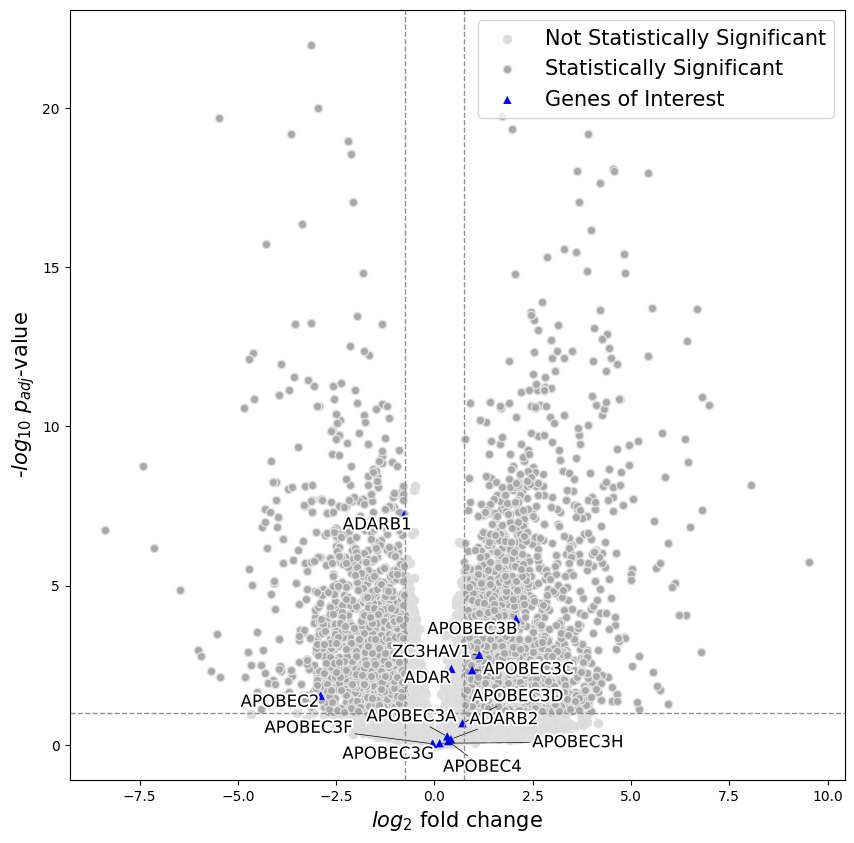

In [7]:

def plot_volcano(data, gene_list, logfc_threshold=.75, padj_threshold=0.1, adjust=True):
    """
    Plot a volcano plot to visualize differential gene expression analysis results.

    Parameters:
    - data (pandas.DataFrame): The data containing gene expression analysis results.
    - filtered_gene_list (list): A list of genes of interest to be highlighted in the plot.
    - logfc_threshold (float, optional): The threshold for log2 fold change. Default is 0.75.
    - padj_threshold (float, optional): The threshold for adjusted p-value. Default is 0.1.
    - adjust (bool, optional): Whether to adjust the position of gene labels to avoid overlap. Default is True.

    """
    plt.figure(figsize=(10, 10))

    # Filter points based on thresholds
    nonsig_points = data[(data['padj'] > padj_threshold) | (abs(data['log2FoldChange']) < logfc_threshold)]
    sig_points = data[(data['padj'] <= padj_threshold) & (abs(data['log2FoldChange']) >= logfc_threshold)]

    # Plot non-significant points
    plt.scatter(nonsig_points['log2FoldChange'], -np.log10(nonsig_points['padj']), c='#DCDCDC', edgecolor='#E0E0E0', label='Not Statistically Significant', marker='o')

    # Plot significant points
    plt.scatter(sig_points['log2FoldChange'], -np.log10(sig_points['padj']), c='#A9A9A9', edgecolor='#E0E0E0', label='Statistically Significant', marker='o')

    # Plot genes in the filtered gene list with a different marker
    genes_of_interest = data[data.index.isin(gene_list)]
    plt.scatter(genes_of_interest['log2FoldChange'], -np.log10(genes_of_interest['padj']), c='b', edgecolor='none', label='Genes of Interest', marker='^')

    # Draw horizontal line for padj threshold
    plt.axhline(y=-np.log10(padj_threshold), color='#909090', linestyle='--', linewidth=1)

    # Draw vertical lines for log2 fold change thresholds
    plt.axvline(x=logfc_threshold, color='#909090', linestyle='--', linewidth=1)
    plt.axvline(x=-logfc_threshold, color='#909090', linestyle='--', linewidth=1)

    # Label points in the filtered gene list
    texts = []
    for gene in gene_list:
        gene_data = data[data.index == gene]
        if not gene_data.empty:
            x = gene_data['log2FoldChange'].values[0]
            y = -np.log10(gene_data['padj'].values[0])
            txt = plt.text(x, y, gene, size=12, ha='center', va='center')  # Decreased font size
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
            texts.append(txt)

    plt.legend(fontsize=15)  # Increased font size of the legend
    plt.xlabel("$log_{2}$ fold change", size=15)
    plt.ylabel("-$log_{10}$ $p_{adj}$-value", size=15)

    if adjust:
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    plt.show()



# Explicitly Add the GeneSymbol column to the DataFrame
dea_results["GeneSymbol"]=dea_results.index
# Call the function to plot the volcano plot highlighting the genes of interest
plot_volcano(dea_results, gene_list)


Next, we carry out Gense set enrichment for the Oxidative Damage Response geneset using GSEApy

2024-12-08 08:02:21,488 [WARNING] Duplicated values found in preranked stats: 0.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


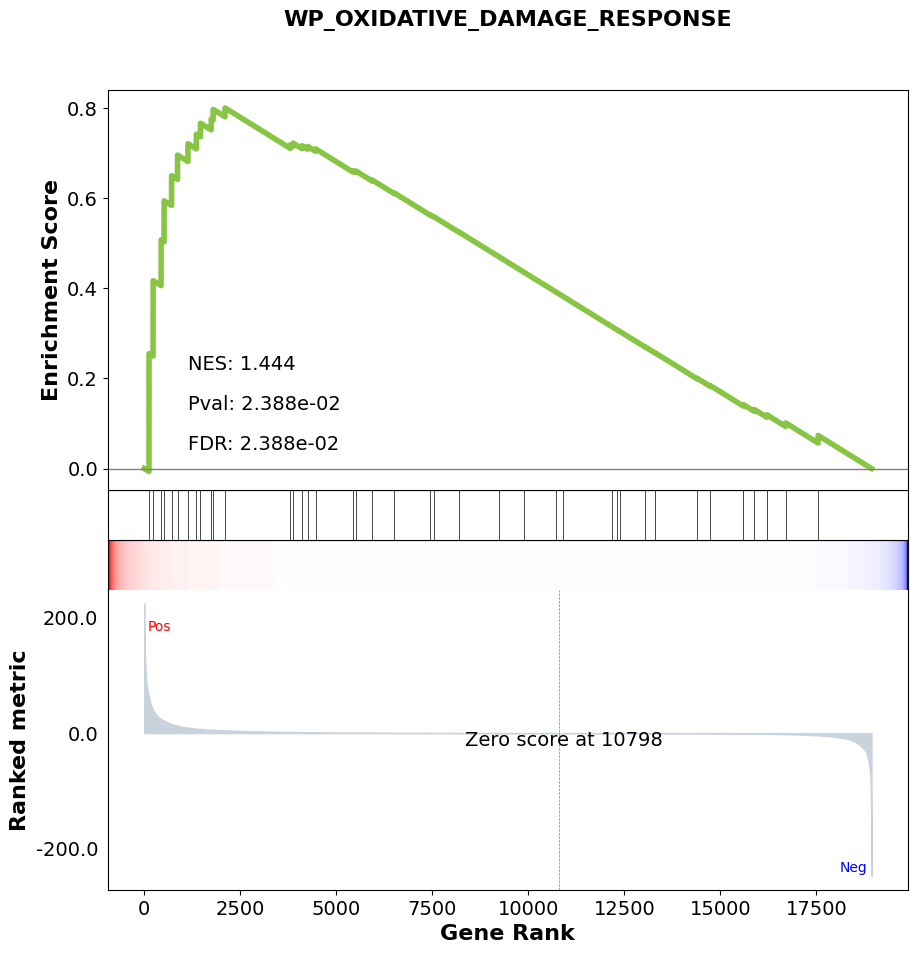

In [8]:

def run_gene_set_enrichment_analysis(dea_results, oxidative_stress_gene_set):
    """
    Runs gene set enrichment analysis using GSEApy for a specified gene set.

    Args:
        dea_results(pandas dataframe): DESeq2 results with columns 'GeneSymbol', 'padj', and 'log2FoldChange'.
        oxidative_stress_gene_set (str): Path to the Oxidative Damage response gene set file.
    """

    # Create a ranking of genes based on the DESeq2 results
    dea_results["-log_padj x lfc"] = -np.log(dea_results["padj"]) * dea_results["log2FoldChange"]
    # Sort the genes by the -log_padj x lfc
    ranked_genes = dea_results[['GeneSymbol', '-log_padj x lfc']].dropna().sort_values('-log_padj x lfc', ascending=False)
    # Reset the index to GeneSymbol column
    ranked_genes.reset_index(drop=True, inplace=True)

    # Run Gene Set Enrichment Analysis
    pre_res = gp.prerank(rnk=ranked_genes, gene_sets=oxidative_stress_gene_set, seed=6, min_size=0, max_size=200)

    # Plot the results
    pre_res.plot(terms="WP_OXIDATIVE_DAMAGE_RESPONSE", figsize=(10, 10))
   

run_gene_set_enrichment_analysis(dea_results, "../WP_OXIDATIVE_DAMAGE_RESPONSE.v2024.1.Hs.gmt")

In order to invesgate the variability of the genes of interest among different replicates we plot the clustermap

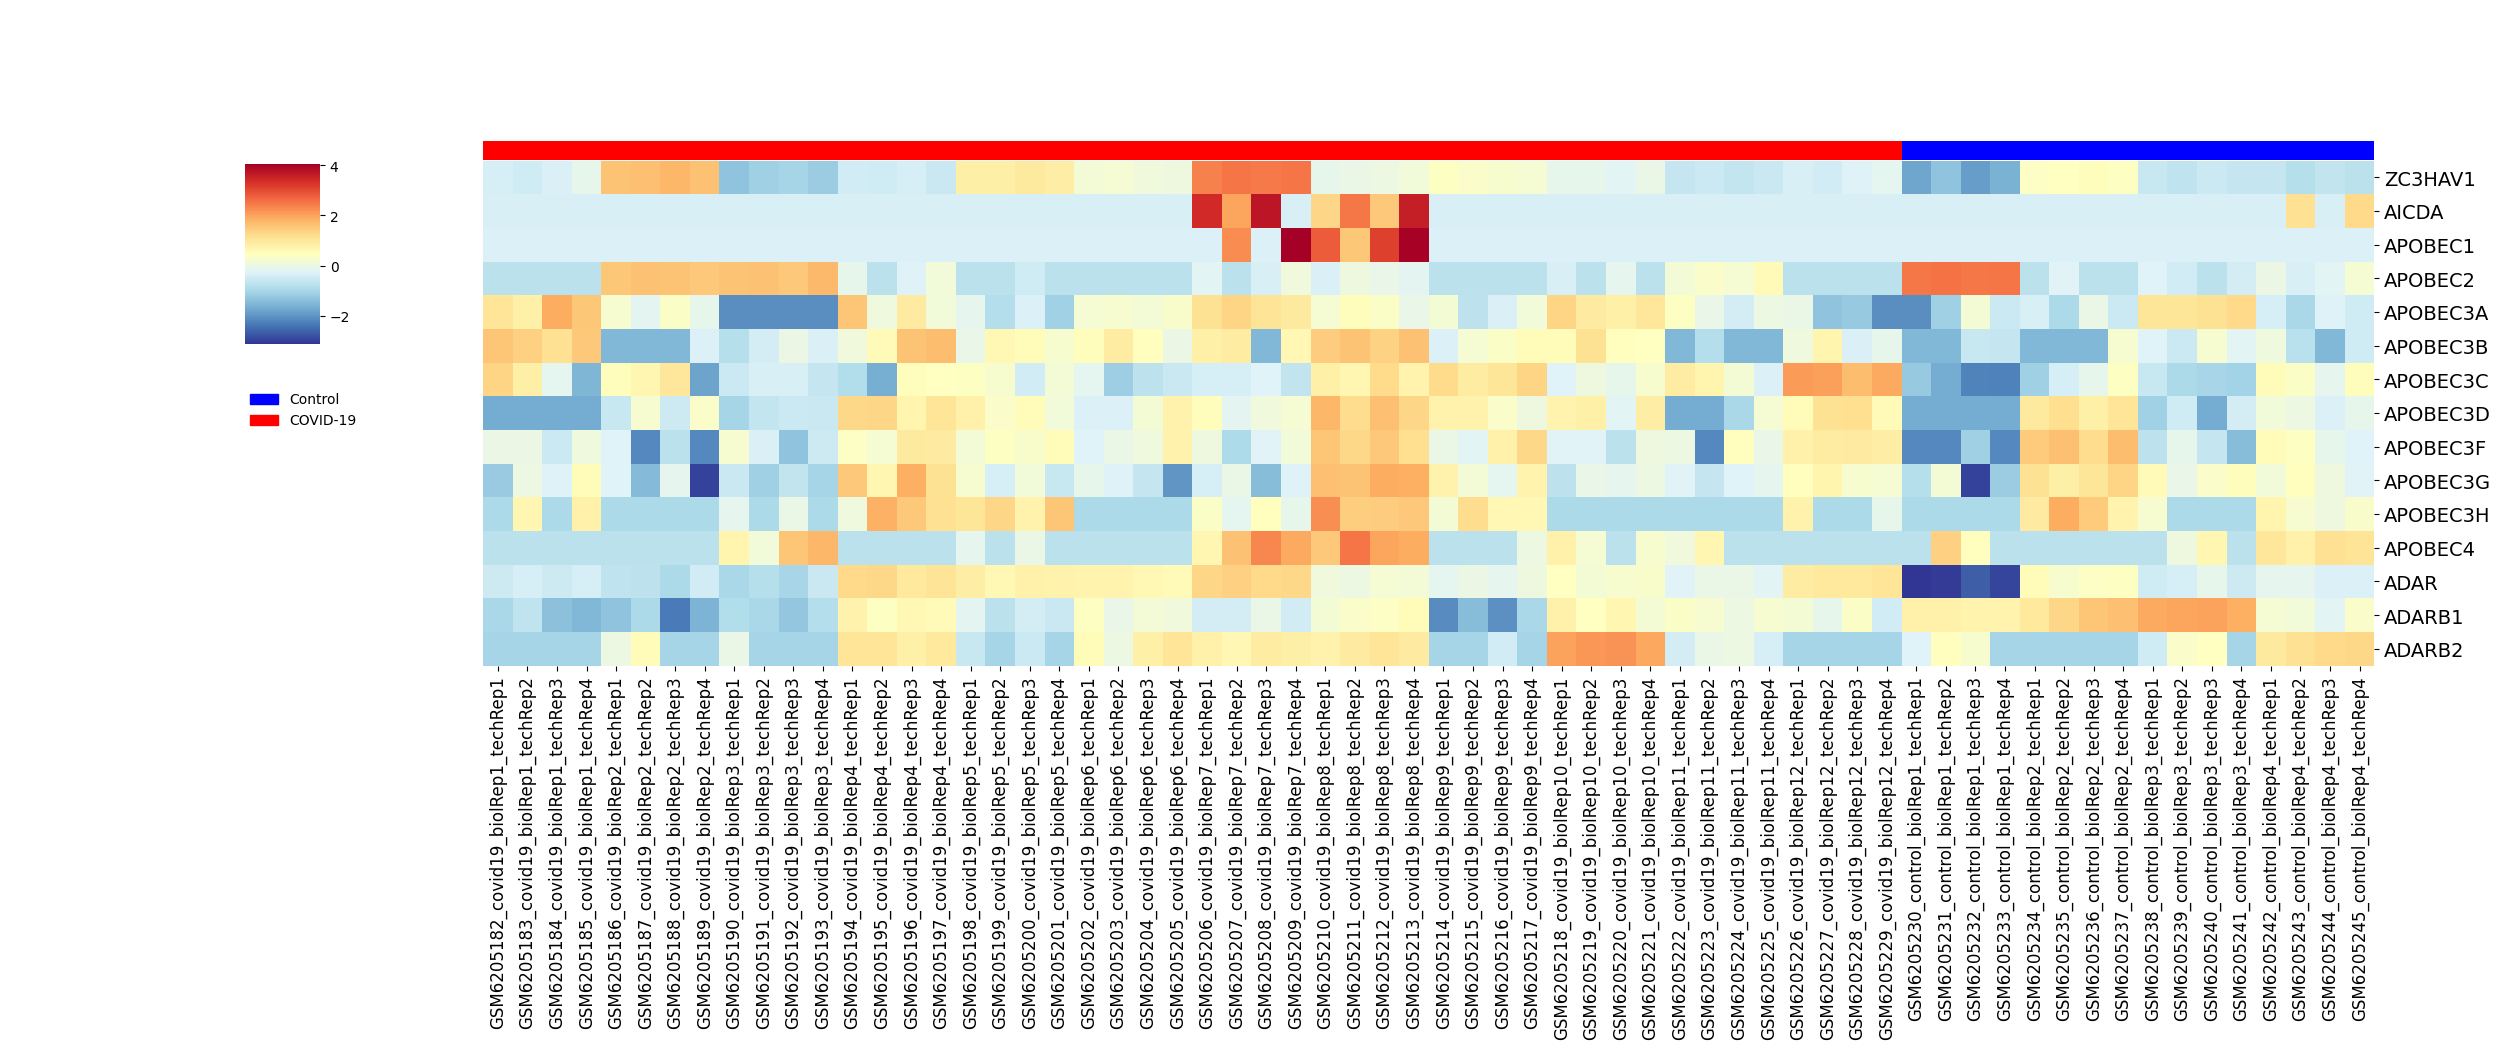

,GSM6205182_covid19_biolRep1_techRep1,GSM6205183_covid19_biolRep1_techRep2,GSM6205184_covid19_biolRep1_techRep3,GSM6205185_covid19_biolRep1_techRep4,GSM6205186_covid19_biolRep2_techRep1,GSM6205187_covid19_biolRep2_techRep2,GSM6205188_covid19_biolRep2_techRep3,GSM6205189_covid19_biolRep2_techRep4,GSM6205190_covid19_biolRep3_techRep1,GSM6205191_covid19_biolRep3_techRep2,...,GSM6205236_control_biolRep2_techRep3,GSM6205237_control_biolRep2_techRep4,GSM6205238_control_biolRep3_techRep1,GSM6205239_control_biolRep3_techRep2,GSM6205240_control_biolRep3_techRep3,GSM6205241_control_biolRep3_techRep4,GSM6205242_control_biolRep4_techRep1,GSM6205243_control_biolRep4_techRep2,GSM6205244_control_biolRep4_techRep3,GSM6205245_control_biolRep4_techRep4
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
ZC3HAV1,5.078610,5.012837,5.121796,5.298874,6.553155,6.596715,6.672823,6.562927,4.383054,4.531509,...,5.750455,5.672669,4.940813,4.838053,4.978950,4.901105,4.905171,4.771213,4.872799,4.815870
AICDA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.405643,0.000000,0.436104
APOBEC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
APOBEC2,0.000000,0.000000,0.000000,0.000000,4.180326,4.342413,4.298425,4.139731,4.300265,4.315877,...,0.000000,0.000000,0.926715,0.567333,0.000000,0.600864,1.391839,0.693413,1.006815,1.778342
APOBEC3A,2.600086,2.393830,3.290539,3.000365,1.924741,1.587589,2.027955,1.660340,0.000000,0.000000,...,1.705097,1.273203,2.580942,2.581497,2.641991,2.761684,1.391839,0.916610,1.498224,1.317306
APOBEC3B,2.915111,2.768396,2.525100,2.854475,0.000000,0.000000,0.000000,1.141208,0.646575,1.030310,...,0.000000,1.665275,1.190673,0.927078,1.676543,1.244466,1.509827,0.693413,0.000000,0.970783
APOBEC3C,3.255393,2.913540,2.263752,1.315752,2.684978,2.807459,3.034741,1.141208,1.996459,2.105077,...,2.302969,2.629106,1.960769,1.719429,1.676543,1.632855,2.714945,2.603183,2.270511,2.685584
APOBEC3D,0.000000,0.000000,0.000000,0.000000,1.082187,1.922482,1.162998,2.000350,0.646575,1.030310,...,2.468490,2.745746,0.567073,1.191091,0.000000,1.244466,1.797918,1.705184,1.359638,1.574161
APOBEC3F,1.789417,1.788034,1.354039,1.864872,1.589694,0.000000,1.162998,0.000000,1.996459,1.526897,...,2.791566,3.184304,1.190673,1.719429,1.283216,0.600864,2.257903,2.140536,1.728403,1.574161


In [9]:

def plot_heatmap_with_clustermap(dds, dea_results, gene_list, metadata):
    """
    Plot a heatmap using the genes of interest for the different replicates.

    Args:
        dds (object): The DESeq2 object containing normalized counts and log1p transformed data.
        dea_results (DataFrame): The Dataframe contatining the DESeq2 results.
        gene_list (list): The list of genes to be used in constructing the heatmap.
        metadata (DataFrame): The DataFrame containing metadata information of the replicates.

    """
    # Extract the normalized counts and log1p transform them with a pseudocount of 1
    dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
    # Extract the normalized counts of the genes of interest
    dds_sigs = dds[:, dea_results[dea_results["GeneSymbol"].isin(gene_list)].index]

    # Create a DataFrame for plotting the heatmap
    grapher = pd.DataFrame(dds_sigs.layers['log1p'].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names)


    # Get the indexes of control and covid conditions
    indexes_condition_control = metadata[metadata['Condition'] == "Control"].index.tolist()
    indexes_condition_covid = metadata[metadata['Condition'] == "Covid"].index.tolist()
    indexes_order = indexes_condition_control + indexes_condition_covid

    # Clean the data and reorder it based on gene_list and indexes_order
    cleaned_data = grapher[indexes_order]
    cleaned_data = cleaned_data.reindex(gene_list)
    cleaned_data.fillna(0, inplace=True)
    cleaned_data = cleaned_data[sorted(cleaned_data.columns)]

    
    # Create a DataFrame to use as col_colors
    col_colors_df = pd.DataFrame(index=cleaned_data.columns)

    # highlight the control and the covid samples with different colors
    col_colors_df.loc[indexes_condition_control, 'color'] = 'blue'  # Color for control columns
    col_colors_df.loc[indexes_condition_covid, 'color'] = 'red'  # Color for covid columns


    # Generate heatmap with marked columns
    heatmap = sns.clustermap(cleaned_data, method='average', z_score=-1, cmap='RdYlBu_r', col_cluster=False, row_cluster=False, col_colors=[col_colors_df['color']],  figsize=(25, 10),cbar_pos=(0.1, .65, 0.03, 0.18) )
    heatmap.ax_heatmap.set_xticklabels(heatmap.ax_heatmap.get_xticklabels(), fontsize=12)
    heatmap.ax_heatmap.set_yticklabels(heatmap.ax_heatmap.get_yticklabels(), fontsize=14)
    heatmap.ax_heatmap.set_ylabel("")



    # Create the legend 
    legend = [Patch(color=color, label=label) for label, color in {'Control': 'blue', 'COVID-19': 'red'}.items()]

    # Add legend to the plot
    plt.legend(handles=legend, loc='upper left', bbox_to_anchor=(-.1, -0.2), frameon=False)

    # Show the plot
    plt.show()
    return cleaned_data

# Call the function to plot the heatmap
plot_heatmap_with_clustermap(dds, dea_results, gene_list, metadata)


At last we plot a heatmap depicting the log2Fold changes for the genes of interest 

/tmp/ipykernel_128256/2418680096.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


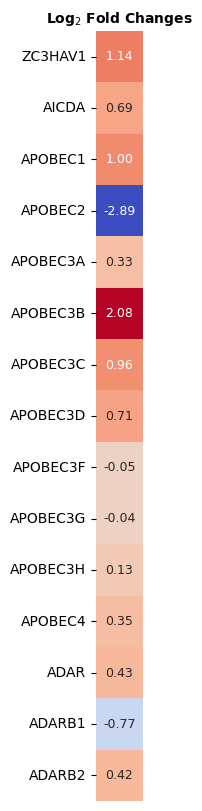

In [10]:
#Extract the LogFolChanges for the genes of interest
log2_fold_changes = [dea_results[dea_results.index == gene]["log2FoldChange"].values[0] for gene in gene_list]
log2_fold_changes_df=pd.DataFrame(data=log2_fold_changes, index=gene_list, columns=["log2FoldChange"])

# Plotting the heatmap
# Set the figure size
plt.figure(figsize=(.6, 10))
# Create the heatmap  
heatmap = sns.heatmap(log2_fold_changes_df, cmap='coolwarm', annot=True, fmt=".2f", cbar=False, annot_kws={"size": 9})
# Set the title
plt.title('Log$_2$ Fold Changes', fontweight='bold', fontsize=10) 
# Turn off x-axis ticks
plt.xticks([])  
# Set the font size for y-axis ticks
heatmap.yaxis.set_tick_params(labelsize=10)  
plt.tight_layout()  
# Display the plot
plt.show()

/tmp/ipykernel_128256/2062897493.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


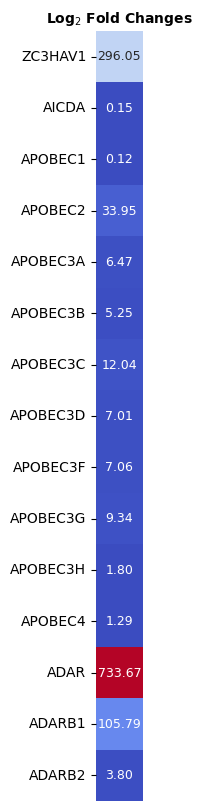

In [11]:
#Extract the LogFolChanges for the genes of interest
basemeans = [dea_results[dea_results.index == gene]["baseMean"].values[0] for gene in gene_list]
basemeans_df=pd.DataFrame(data=basemeans, index=gene_list, columns=["baseMean"])

# Plotting the heatmap
# Set the figure size
plt.figure(figsize=(.6, 10))
# Create the heatmap  
heatmap = sns.heatmap(basemeans_df, cmap='coolwarm', annot=True, fmt=".2f", cbar=False, annot_kws={"size": 9})
# Set the title
plt.title('Log$_2$ Fold Changes', fontweight='bold', fontsize=10) 
# Turn off x-axis ticks
plt.xticks([])  
# Set the font size for y-axis ticks
heatmap.yaxis.set_tick_params(labelsize=10)  
plt.tight_layout()  
# Display the plot
plt.show()

Save the processed count matrix and metadata

In [12]:
# Save the count matrix
counts_df.to_csv('../bulk_transcriptomic_analysis_processed_count_matrix.tsv', sep='\t')

